## TF - IDF Formulation

###### d (document) = row

###### D (corpus) = honest responses


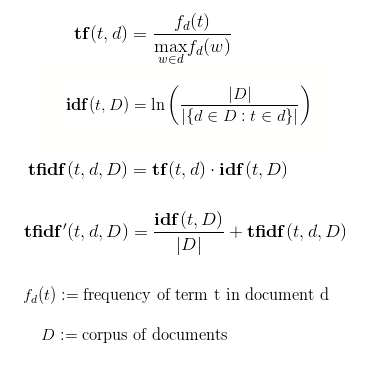

###### For the given dataset, there are 5 possible values for each question 1, 2, 3, 4, 5. The shape of the objects is:

#### TF matrix = ( 5 , number of rows )
#### IDF  = vector of length 5
#### TF - IDF score = TF.transpose * IDF

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_data = pd.read_csv("train_dataset.csv")
test_data = pd.read_csv("test_dataset.csv")

In [2]:
def compute_tf_idf(data_matrix):

    # Compute tf_matrix
    n = len(data_matrix)

    # 5 possible values [1,2,3,4,5] * number of rows
    tf_matrix = np.zeros((5, n))

    idf_vector = np.zeros(5)

    for index, row in data_matrix.iterrows():
        features = np.array(row)[0:-1]

        # Get unique values and their frequency
        (value, count) = np.unique(features, return_counts = True)
        
        for i in range(len(value)):
            # Add tf value in matrix
            tf_matrix[value[i] - 1, index] = count[i] / len(value)

            # Count frequency for honest responses only:
            if row[-1] == 'H':
                idf_vector[value[i] - 1] += 1

    # Compute IDF for honest responses only (n / 2)
    idf_vector = np.log((n / 2) / idf_vector)
    
    # Compute TF * IDF
    score = np.sum(tf_matrix.T * idf_vector, axis = 1)
    return score


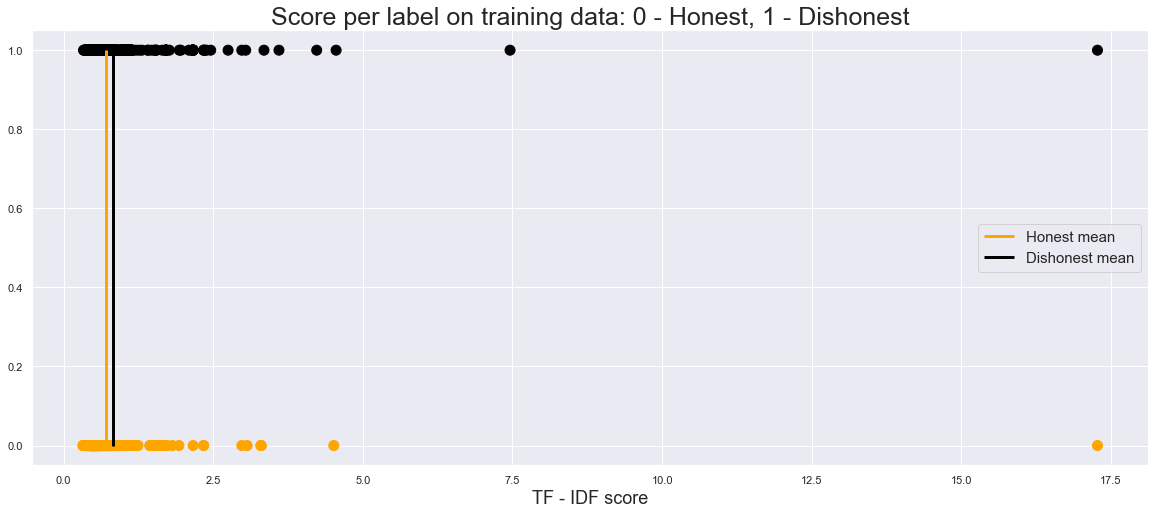

In [193]:
# Compute TF - IDF score for each row

score = compute_tf_idf(train_data)
labels = train_data['CONDITION'].replace('H', 0).replace('D', 1)

import seaborn as sns
sns.set_theme(style = 'darkgrid')
plt.rcParams["figure.figsize"] = (20,8)

# Plot scores

plt.scatter(score, labels, c = ["black" if l == 1 else "orange" for l in labels], s = 100)
line1 = plt.vlines(score[0:int(n/2)].mean(), 0, 1, lw = 3, color = 'orange')
line2 = plt.vlines(score[int(n/2):].mean(), 0, 1, lw = 3, color = 'black')
plt.xlabel("TF - IDF score", size = 18)
plt.title("Score per label on training data: 0 - Honest, 1 - Dishonest", size = 25)
plt.legend([line1, line2], ['Honest mean', 'Dishonest mean'], fontsize = 15)

In [171]:
print("Honest score: ")
print(score[:int(n/2)].mean())

print("\nFalse score: ")
print(score[int(n/2):].mean())

mean_diffrence = (score[int(n/2):].mean() + score[:int(n/2)].mean()) / 2

Honest score: 
0.7044384945653621

False score: 
0.8272406784071663


Honest score: 
0.9148358485760627

False score: 
1.322475192456502


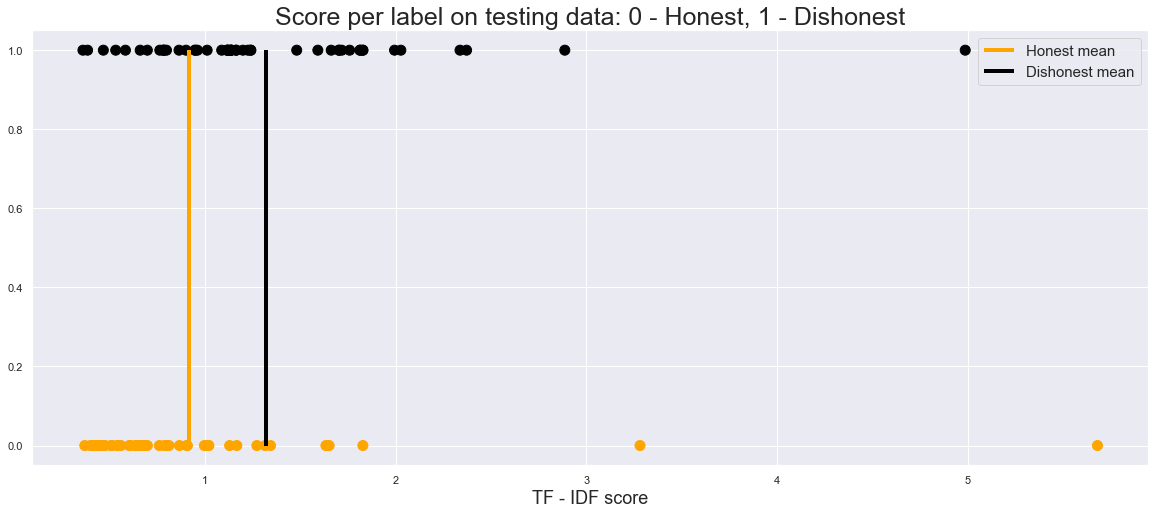

In [195]:
score = compute_tf_idf(test_data)
labels = test_data['CONDITION'].replace('H', 0).replace('D', 1)
n = len(test_data)

# Plot scores
plt.scatter(score, labels, c= ["black" if l == 1 else "orange" for l in labels], s = 100)
line1 = plt.vlines(score[0:int(n/2)].mean(), 0, 1, lw = 4, color = 'orange')
line2 = plt.vlines(score[int(n/2):].mean(), 0, 1, lw = 4, color = 'black')
plt.xlabel("TF - IDF score", size = 18)
plt.title("Score per label on testing data: 0 - Honest, 1 - Dishonest", size = 25)
plt.legend([line1, line2], ['Honest mean', 'Dishonest mean'], fontsize = 15)

print("Honest score: ")
print(score[:int(n/2)].mean())

print("\nFalse score: ")
print(score[int(n/2):].mean())

### Computing accuracy on testing data using the training mean difference of training data as a threshold

In [202]:
pred = [0 if s < mean_diffrence else 1 for s in score]

print("Prediction accuracy: ")
print(sum(pred == labels) / len(pred))

Prediction accuracy: 
0.72


In [218]:
# Grid search for optimal threshold:

best_threshold, best_accuracy = 0, 0

grid_search = np.arange(0.5, 1.5, 0.0001)

for threshold in grid_search:
    pred = [0 if s < threshold else 1 for s in score]
    acc = sum(pred == labels) / len(pred)
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = threshold
        
print('Best Accuracy: ')
print(best_accuracy)

print("\nOptimal threshold: ")
print(best_threshold)

Best Accuracy: 
0.73

Optimal threshold: 
0.7617999999999712


# Vectorize data and classify

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

corpus = []
for index, row in train_data.astype('string').iterrows():
    s = ''
    for i in range(11): s += 'n' + str(row[i]) + ' '
    corpus.append(s)
    
vocabulary = ['n1', 'n2', 'n3', 'n4', 'n5']
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)),
                 ('tfid', TfidfTransformer())]).fit(corpus)

print(pipe['count'].transform(corpus).toarray())
print(pipe['tfid'].idf_)

train_X = pipe.transform(corpus)
train_y = train_data['CONDITION'].replace('H', 0).replace('D', 1)

[[6 2 1 2 0]
 [6 3 1 1 0]
 [5 3 3 0 0]
 ...
 [9 1 0 0 1]
 [7 0 2 2 0]
 [7 0 3 0 1]]
[1.12726983 1.13498195 1.33737456 1.54367808 2.22716335]


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


test_corpus = []
for index, row in test_data.astype('string').iterrows():
    s = ''
    for i in range(11): s += 'n' + str(row[i]) + ' '
    test_corpus.append(s)
    
test_X = pipe.transform(test_corpus)
test_y = list(test_data['CONDITION'].replace('H', 0).replace('D', 1))

clf = LogisticRegression().fit(train_X, train_y)
y_pred = clf.predict(test_X)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(accuracy_score(y_pred, test_y)))

Accuracy of logistic regression classifier on test set: 0.76


In [62]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf').fit(train_X, train_y)
y_pred = clf.predict(test_X)
print('Accuracy of SVM on test set: {:.2f}'.format(accuracy_score(y_pred, test_y)))

Accuracy of SVM on test set: 0.77


In [64]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(max_iter=300, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1)
clf.fit(train_X, train_y)
y_pred = clf.predict(test_X)
print('Accuracy of NN classifier on test set: {:.2f}'.format(accuracy_score(y_pred, test_y)))

Accuracy of NN classifier on test set: 0.79


In [65]:
from sklearn import tree

clf = tree.DecisionTreeClassifier().fit(train_X, train_y)
y_pred = clf.predict(test_X)
print('Accuracy of decision trees classifier on test set: {:.2f}'.format(accuracy_score(y_pred, test_y)))

Accuracy of decision trees classifier on test set: 0.75
